In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from datetime import datetime
plt.rcParams['figure.figsize']=(15,9)

# loading machine learning models
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [2]:
#function for formatting date time according to convenience
class date_format():
    def __init__(self,date):
#         date = ' '.join(date.split(' ')[:-1])       

        self.date_strip = datetime.strptime(date, '%m/%d/%Y %I:%M:%S %p')
    
    def is_weekday(self):
        if self.date_strip.weekday() ==5 or self.date_strip.weekday() == 6:
            return 0
        else:
            return 1
    def hour(self):
        return self.date_strip.hour
    
    def minute(self):
        return self.date_strip.minute

In [3]:
#Read the data 
def read_data(path):
    return pd.read_csv(path)

In [4]:
raw_data = read_data("orders.csv")

In [5]:
null_data=raw_data[raw_data['Response Distance'].isnull()]
print("{} % of the raw data is null for Response Distance and can be deleted".format(np.round(null_data.shape[0]/raw_data.shape[0],2)))

0.06 % of the raw data is null for Response Distance and can be deleted


In [7]:
# Since the null data for response data is low removing from the dataset
deleted_raw_data = raw_data.copy()
deleted_raw_data=deleted_raw_data.loc[deleted_raw_data['Response Distance'].dropna(axis=0).index]
deleted_raw_data=pd.concat((deleted_raw_data,pd.get_dummies(deleted_raw_data['Service Type'])),axis=1)

In [8]:
#splitting the data on the basis of Reject Time and Cancel Time and Converted trip data
cancelled_time_data =deleted_raw_data.loc[deleted_raw_data['Cancel Time'].dropna().index]
reject_time_data = deleted_raw_data.loc[deleted_raw_data['Reject Time'].dropna().index]
cancel_trip_index=set(list(cancelled_time_data.index) + list(reject_time_data.index))
converted_trips=deleted_raw_data.loc[[index for index in deleted_raw_data.index if index not in cancel_trip_index]]

In [9]:
# preprocessing and converting Cancel Time , Placed Time and Reject Time into date time format and calculating time and time span differences across
# for the customer cancelled trip data
cancelled_time_data['Response in(secs)'] = cancelled_time_data['Response Time'].apply(lambda date : date_format(date).date_strip)  - cancelled_time_data['Placed Time'].apply(lambda date : date_format(date).date_strip)
cancelled_time_data['Cancel in(secs)'] = cancelled_time_data['Cancel Time'].apply(lambda date : date_format(date).date_strip)  - cancelled_time_data['Placed Time'].apply(lambda date : date_format(date).date_strip)

#for the driver rejected trip data
reject_time_data['Response in(secs)'] = reject_time_data['Response Time'].apply(lambda date : date_format(date).date_strip)  - reject_time_data['Placed Time'].apply(lambda date : date_format(date).date_strip)
reject_time_data['Cancel in(secs)'] = reject_time_data['Reject Time'].apply(lambda date : date_format(date).date_strip)  - reject_time_data['Placed Time'].apply(lambda date : date_format(date).date_strip)

#for the converted trips data
converted_trips['Response in(secs)'] = converted_trips['Response Time'].apply(lambda date : date_format(date).date_strip)  - converted_trips['Placed Time'].apply(lambda date : date_format(date).date_strip)

#Converting the time differences in secs
cancelled_time_data["Response in(secs)"] = cancelled_time_data["Response in(secs)"].apply(lambda time: time.seconds)
cancelled_time_data["Cancel in(secs)"] = cancelled_time_data["Cancel in(secs)"].apply(lambda time: time.seconds)

reject_time_data["Response in(secs)"] = reject_time_data["Response in(secs)"].apply(lambda time: time.seconds)
reject_time_data["Cancel in(secs)"] = reject_time_data["Cancel in(secs)"].apply(lambda time: time.seconds)

converted_trips["Response in(secs)"] = converted_trips["Response in(secs)"].apply(lambda time: time.seconds)

#Converted Placed Time into Placed Hour
cancelled_time_data['Placed Hour']=cancelled_time_data['Placed Time'].apply(lambda time:date_format(time).hour())
reject_time_data['Placed Hour']=reject_time_data['Placed Time'].apply(lambda time:date_format(time).hour())
converted_trips['Placed Hour']=converted_trips['Placed Time'].apply(lambda time:date_format(time).hour())


#Converting Placed Time into Weekday/Weekend field

cancelled_time_data['Weekday/Weekend']=cancelled_time_data['Placed Time'].apply(lambda time:date_format(time).is_weekday())
reject_time_data['Weekday/Weekend']=reject_time_data['Placed Time'].apply(lambda time:date_format(time).is_weekday())
converted_trips['Weekday/Weekend']=converted_trips['Placed Time'].apply(lambda time:date_format(time).is_weekday())

#Calculating The Driver Reaction Time

converted_trips['Driver Reaction Time'] = converted_trips['Response in(secs)']/converted_trips['Available Drivers']#*converted_trips['Hours']#*converted_trips['Response Distance']
cancelled_time_data['Driver Reaction Time'] = cancelled_time_data['Response in(secs)']/cancelled_time_data['Available Drivers']#*cancelled_time_data['Hours'] #* cancelled_time_data['Response Distance']
reject_time_data['Driver Reaction Time'] = reject_time_data['Response in(secs)']/reject_time_data['Available Drivers']#*reject_time_data['Hours'] #* reject_time_data['Response Distance']


#Labelling the data with positive and negative values (1 and 0)
converted_trips['Labels']= np.zeros(converted_trips.shape[0])
cancelled_time_data['Labels'] = np.ones(cancelled_time_data.shape[0])
reject_time_data['Labels'] = np.ones(reject_time_data.shape[0])


#columns that can be dropped to prepare the dataframe to be fed for model preparation
columns_to_drop = ['Cancel Time','Placed Time','Order ID','Reject Time','Response Time','Service Type']
cancelled_time_data.drop(columns_to_drop,axis=1,inplace=True)
reject_time_data.drop(columns_to_drop,axis=1,inplace=True)
converted_trips.drop(columns_to_drop,axis=1,inplace=True)

In [13]:
converted_trips..any()

Available Drivers       False
Response Distance       False
Motorcycle              False
Van                     False
Response in(secs)       False
Placed Hour             False
Weekday/Weekend         False
Driver Reaction Time    False
Labels                  False
dtype: bool

In [14]:
reject_time_data.isnull().any()

Available Drivers       False
Response Distance       False
Motorcycle              False
Van                     False
Response in(secs)       False
Cancel in(secs)         False
Placed Hour             False
Weekday/Weekend         False
Driver Reaction Time    False
Labels                  False
dtype: bool

In [41]:
# Keeping a log transformed data frame for comparison purpose. The objective of the log transform is to create normally distributed  feature
# columns_to_transfer = ['Labels','Motorcycle','Placed Hour','Van','Weekday/Weekend'
cancelled_time_data_log = np.log(cancelled_time_data)
reject_time_data_log  = np.log(reject_time_data)
converted_trips_log = np.log(converted_trips)

transformed_df = pd.concat([cancelled_time_data,reject_time_data,converted_trips],axis=0)
transformed_df_log = pd.concat([cancelled_time_data_log,reject_time_data_log,converted_trips_log],axis=0)
transformed_df.drop("Cancel in(secs)",axis=1,inplace=True)
transformed_df_log.drop("Cancel in(secs)",axis=1,inplace=True)
columns_to_transfer = ["Available Drivers",'Labels','Motorcycle','Placed Hour','Van','Weekday/Weekend']
for cols in columns_to_transfer:
    transformed_df_log[cols] = transformed_df[cols]

C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting b

In [17]:
transformed_df_log.isnull().any()

Available Drivers       False
Driver Reaction Time    False
Labels                  False
Motorcycle              False
Placed Hour             False
Response Distance       False
Response in(secs)       False
Van                     False
Weekday/Weekend         False
dtype: bool

In [18]:
transformed_df.isnull().any()

Available Drivers       False
Driver Reaction Time    False
Labels                  False
Motorcycle              False
Placed Hour             False
Response Distance       False
Response in(secs)       False
Van                     False
Weekday/Weekend         False
dtype: bool

In [32]:
transformed_df.head()

,Available Drivers,Driver Reaction Time,Labels,Motorcycle,Placed Hour,Response Distance,Response in(secs),Van,Weekday/Weekend
8,13,4.538462,1.0,0,8,9835.0,59,1,1
13,92,0.076087,1.0,0,8,2731.0,7,1,1
28,114,0.078947,1.0,0,9,557.0,9,1,1
34,39,1.282051,1.0,0,9,6411.0,50,1,1
45,118,0.067797,1.0,0,10,949.0,8,1,1


In [42]:
transformed_df_log.head()


,Available Drivers,Driver Reaction Time,Labels,Motorcycle,Placed Hour,Response Distance,Response in(secs),Van,Weekday/Weekend
8,13,1.512588,1.0,0,8,9.193703,4.077537,1,1
13,92,-2.575878,1.0,0,8,7.912423,1.945910,1,1
28,114,-2.538974,1.0,0,9,6.322565,2.197225,1,1
34,39,0.248461,1.0,0,9,8.765771,3.912023,1,1
45,118,-2.691243,1.0,0,10,6.855409,2.079442,1,1


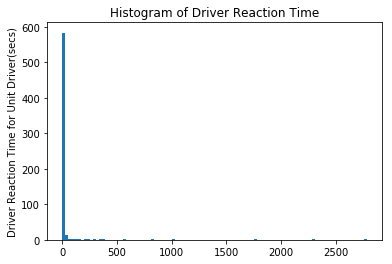

Text(0,0.5,'Driver Reaction Time for Unit Driver(secs)')

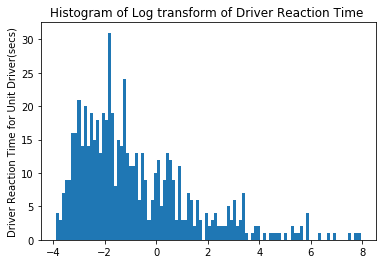

In [81]:
plt.hist((reject_time_data["Driver Reaction Time"]),bins=100);
plt.title("Histogram of Driver Reaction Time")
plt.ylabel("Driver Reaction Time for Unit Driver(secs)")
# plt.axis([0,550,0,1200])
plt.show()
plt.hist(np.log(reject_time_data["Driver Reaction Time"]),bins=100);
plt.title("Histogram of Log transform of Driver Reaction Time ")
plt.ylabel("Driver Reaction Time for Unit Driver(secs)")
         #/np.log("Available Drivers"),bins=100)

In [121]:
transformed_df.head()

,Available Drivers,Cancel in(secs),Driver Reaction Time,Labels,Motorcycle,Placed Hour,Response Distance,Response in(secs),Van,Weekday/Weekend
8,13,90.0,4.538462,1.0,0,8,9835.0,59,1,1
13,92,20.0,0.076087,1.0,0,8,2731.0,7,1,1
28,114,110.0,0.078947,1.0,0,9,557.0,9,1,1
34,39,58.0,1.282051,1.0,0,9,6411.0,50,1,1
45,118,55.0,0.067797,1.0,0,10,949.0,8,1,1


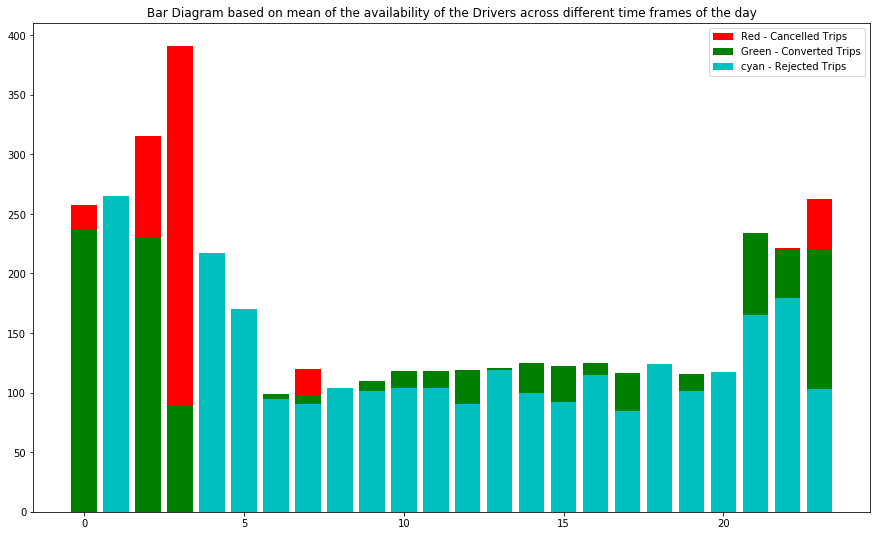

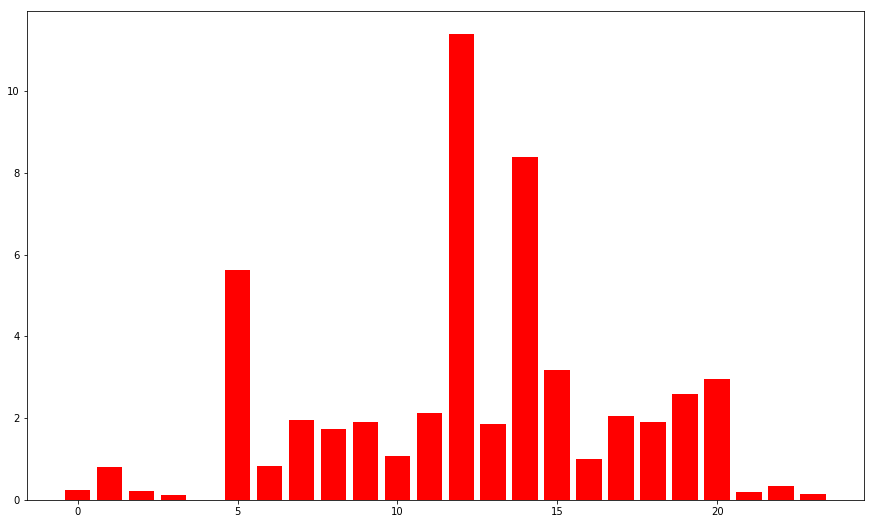

Text(0.5,1,'Bar Diagram based on mean of the availability of the Drivers across different time frames of the day')

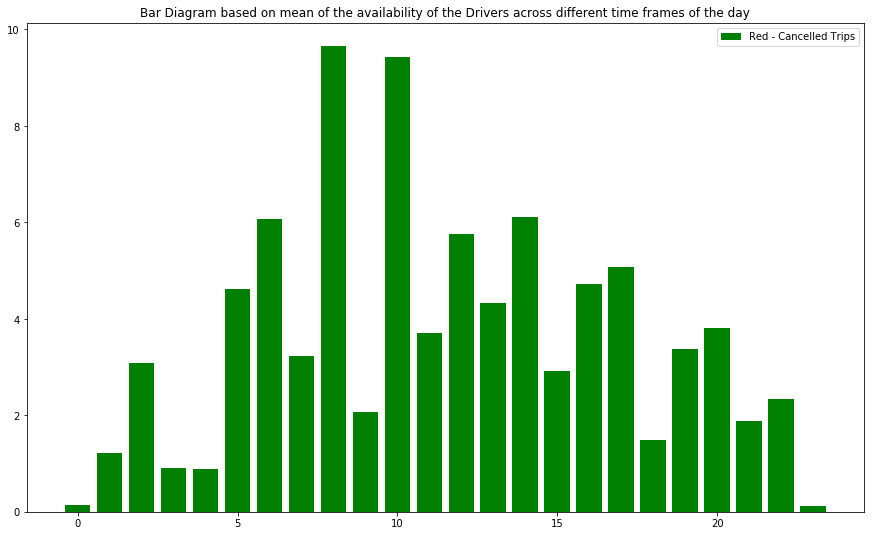

In [45]:
canc_mean=cancelled_time_data.groupby(['Placed Hour']).mean()
conv_mean = converted_trips.groupby(['Placed Hour']).mean()
rej_mean = reject_time_data.groupby(['Placed Hour']).mean()
columns = "Available Drivers"
plt.bar(canc_mean.index,canc_mean[columns],color="r")
plt.bar(conv_mean.index,conv_mean[columns],color="g")
plt.bar(rej_mean.index,rej_mean[columns],color='c')
plt.legend(['Red - Cancelled Trips','Green - Converted Trips', 'cyan - Rejected Trips'])
plt.title("Bar Diagram based on mean of the availability of the Drivers across different time frames of the day")
plt.show()
columns = "Driver Reaction Time"
plt.bar(canc_mean.index,canc_mean[columns],color="r")
plt.show()
plt.bar(conv_mean.index,conv_mean[columns],color="g")
# plt.bar(rej_mean.index,rej_mean[columns],color='c')
plt.legend(['Red - Cancelled Trips','Green - Converted Trips', 'cyan - Rejected Trips'])
plt.title("Bar Diagram based on mean of the availability of the Drivers across different time frames of the day")

<Container object of 21 artists>

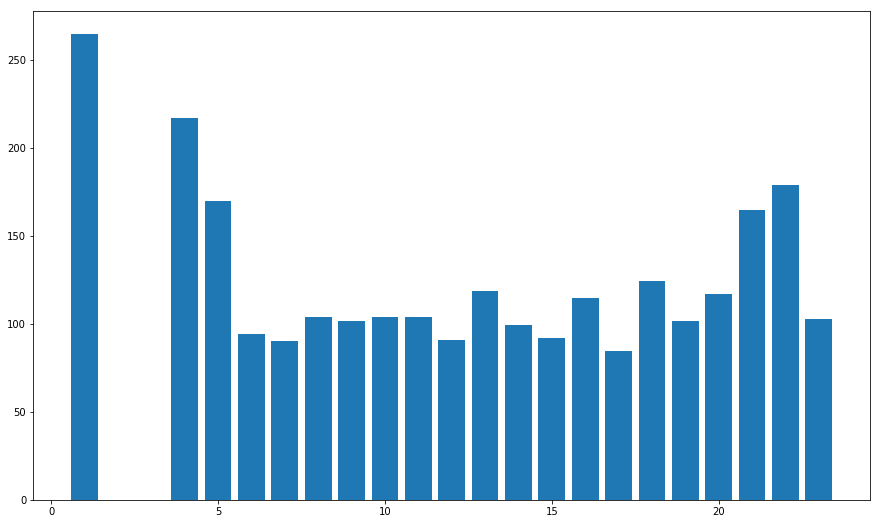

In [37]:
plt.bar(reject_time_data.groupby(['Placed Hour']).mean()['Available Drivers'].index,reject_time_data.groupby(['Placed Hour']).mean()['Available Drivers'])

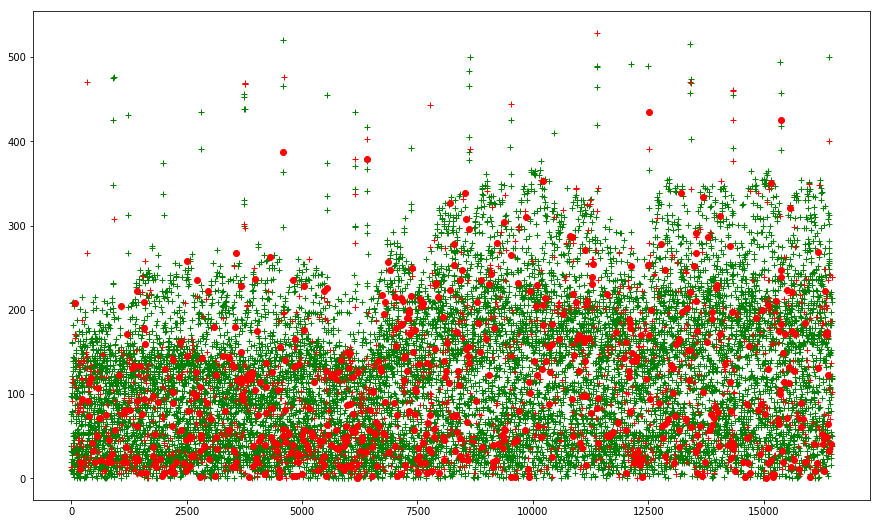

In [12]:
plt.plot(converted_trips["Available Drivers"],'g+')
plt.plot(cancelled_time_data["Available Drivers"],'r+')
plt.plot(reject_time_data["Available Drivers"],'ro')

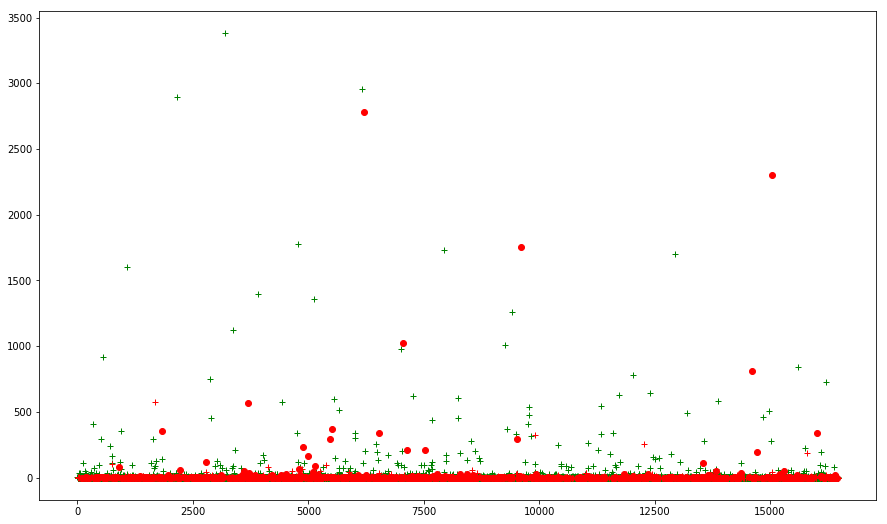

In [13]:
plt.plot(converted_trips["Driver Reaction Time"],'g+')
plt.plot(cancelled_time_data["Driver Reaction Time"],'r+')
plt.plot(reject_time_data["Driver Reaction Time"],'ro')

In [68]:
def train_model(df,model,train_size,name_of_algo):
    X_train,X_test,y_train,y_test=train_test_split(df.drop('Labels',axis=1),df['Labels'],train_size=train_size,stratify=df['Labels'],random_state=42)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)
    print("Classification report with trained set size {} % of dataset and applying {} is".format(train_size*100,name_of_algo))
    print(classification_report(y_test,y_pred))
    print("The roc auc score is",np.round(roc_auc_score(y_test,y_pred),2))
#     roc_curve(y_test,model.predict_proba(y_test[[0,1]])[:,1].reshape(-1,1),sample_weight="balanced")

In [153]:
transformed_df_log.head()

,Available Drivers,Driver Reaction Time,Labels,Motorcycle,Placed Hour,Response Distance,Response in(secs),Van,Weekday/Weekend
8,2.564949,1.512588,1.0,0,8,9.193703,4.077537,1,1
13,4.521789,-2.575878,1.0,0,8,7.912423,1.945910,1,1
28,4.736198,-2.538974,1.0,0,9,6.322565,2.197225,1,1
34,3.663562,0.248461,1.0,0,9,8.765771,3.912023,1,1
45,4.770685,-2.691243,1.0,0,10,6.855409,2.079442,1,1


In [53]:
import imblearn
from imblearn.over_sampling import BorderlineSMOTE
b_smote = BorderlineSMOTE()


#upsampling the transformed_df 
X_resampled,y_resampled=(b_smote.fit_resample(transformed_df.drop('Labels',axis=1),transformed_df['Labels']))
up_sampled_x=pd.DataFrame(X_resampled,columns=['Available Drivers','Driver Reaction Time','Motorcycle','Placed Hour','Response Distance','Response in(secs)','Van','Weekday/Weekend'])
up_sampled_y = pd.DataFrame(y_resampled,columns=['Labels'])
transformed_upsampled = pd.concat((up_sampled_x,up_sampled_y),axis=1)

#upsampling the transformed df log

# columns_to_transfer = ['Labels','Motorcycle','Placed Hour','Van','Weekday/Weekend']
transformed_upsampled_log = np.log(transformed_upsampled)
for cols in columns_to_transfer:
    transformed_upsampled_log[cols] = transformed_upsampled[cols]

C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [54]:
transformed_upsampled.isnull().any()

Available Drivers       False
Driver Reaction Time    False
Motorcycle              False
Placed Hour             False
Response Distance       False
Response in(secs)       False
Van                     False
Weekday/Weekend         False
Labels                  False
dtype: bool

In [55]:

transformed_upsampled_log.isnull().any()

Available Drivers       False
Driver Reaction Time    False
Motorcycle              False
Placed Hour             False
Response Distance       False
Response in(secs)       False
Van                     False
Weekday/Weekend         False
Labels                  False
dtype: bool

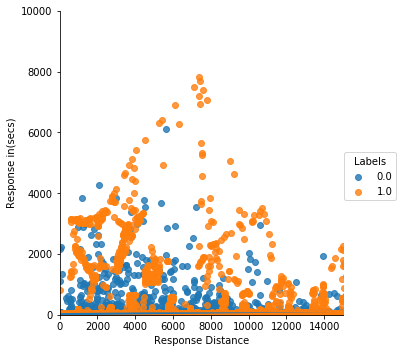

[0, 15000, 0, 10000]

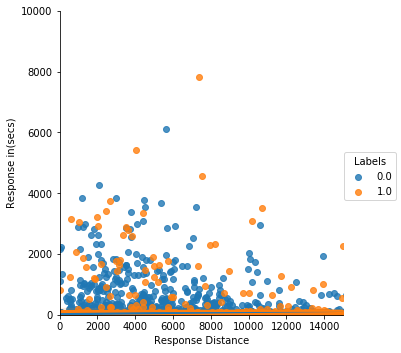

In [83]:
sns.lmplot(x="Response Distance",y="Response in(secs)",hue="Labels",data=transformed_upsampled)
plt.axis([0,15000,0,10000])
plt.show()
sns.lmplot(x="Response Distance",y="Response in(secs)",hue="Labels",data=transformed_df)
plt.axis([0,15000,0,10000])

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,roc_curve
from sklearn.svm import SVC
#X_train,y_train,X_test,y_test = 
# df = final_df_pca
train_size = 0.9
logreg = LogisticRegression(class_weight="balanced",n_jobs=-1)
col_2_drop = ["Available Drivers"]
train_model(transformed_df.drop(col_2_drop,axis=1),logreg,train_size,name_of_algo="logistic regression")
train_model(transformed_df_log.drop(col_2_drop,axis=1),logreg,train_size,name_of_algo="logistic regression")
train_model(transformed_upsampled.drop(col_2_drop,axis=1),logreg,train_size,name_of_algo="logistic regression")
train_model(transformed_upsampled_log.drop(col_2_drop,axis=1),logreg,train_size,name_of_algo="logistic regression")

C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Classification report with trained set size 90.0 % of dataset and applying logistic regression is
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.83      1370
         1.0       0.18      0.36      0.24       186

    accuracy                           0.73      1556
   macro avg       0.54      0.57      0.54      1556
weighted avg       0.81      0.73      0.76      1556

The roc auc score is 0.57
Classification report with trained set size 90.0 % of dataset and applying logistic regression is
              precision    recall  f1-score   support

         0.0       0.91      0.66      0.76      1370
         1.0       0.18      0.54      0.27       186

    accuracy                           0.64      1556
   macro avg       0.55      0.60      0.52      1556
weighted avg       0.83      0.64      0.70      1556

The roc auc score is 0.6


C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Classification report with trained set size 90.0 % of dataset and applying logistic regression is
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68      1370
         1.0       0.69      0.48      0.56      1370

    accuracy                           0.63      2740
   macro avg       0.65      0.63      0.62      2740
weighted avg       0.65      0.63      0.62      2740

The roc auc score is 0.63
Classification report with trained set size 90.0 % of dataset and applying logistic regression is
              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66      1370
         1.0       0.65      0.59      0.62      1370

    accuracy                           0.64      2740
   macro avg       0.64      0.64      0.64      2740
weighted avg       0.64      0.64      0.64      2740

The roc auc score is 0.64


C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [70]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(oob_score=True,n_jobs=-1,n_estimators=150)
train_model(transformed_upsampled,rf_classifier,0.8,"random Forrest classfier")

Classification report with trained set size 80.0 % of dataset and applying random Forrest classfier is
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      2740
         1.0       0.95      0.89      0.92      2740

    accuracy                           0.92      5480
   macro avg       0.92      0.92      0.92      5480
weighted avg       0.92      0.92      0.92      5480

The roc auc score is 0.92


In [71]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(oob_score=True,n_jobs=-1,n_estimators=150)
train_model(transformed_upsampled_log,rf_classifier,0.8,"random Forrest classfier")

Classification report with trained set size 80.0 % of dataset and applying random Forrest classfier is
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      2740
         1.0       0.95      0.89      0.92      2740

    accuracy                           0.92      5480
   macro avg       0.92      0.92      0.92      5480
weighted avg       0.92      0.92      0.92      5480

The roc auc score is 0.92


In [108]:
pd.DataFrame(np.round(rf_classifier.feature_importances_*100,2),index=transformed_upsampled.columns[:-1],columns=["Importance of Feautres in %"])

,Importance of Feautres in %
Available Drivers,12.25
Driver Reaction Time,11.79
Motorcycle,3.58
Placed Hour,16.04
Response Distance,21.68
Response in(secs),16.47
Van,3.27
Weekday/Weekend,14.91


In [111]:
from sklearn.svm import SVC
svc = SVC(class_weight="balanced")
train_model(transformed_upsampled_log,svc,0.8,"Support Vector Classifier")

C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Classification report with trained set size 80.0 % of dataset and applying Support Vector Classifier is
              precision    recall  f1-score   support

         0.0       0.68      0.73      0.71      2740
         1.0       0.71      0.66      0.68      2740

    accuracy                           0.70      5480
   macro avg       0.70      0.70      0.70      5480
weighted avg       0.70      0.70      0.70      5480

The roc auc score is 0.7


In [113]:
import xgboost
xgb_classifier = xgboost.XGBClassifier()
train_model(transformed_upsampled_log,xgb_classifier,0.8,"XGBOOST classfier")

Classification report with trained set size 80.0 % of dataset and applying XGBOOST classfier is
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      2740
         1.0       0.96      0.84      0.89      2740

    accuracy                           0.90      5480
   macro avg       0.91      0.90      0.90      5480
weighted avg       0.91      0.90      0.90      5480

The roc auc score is 0.9
